In [2]:
import torchvision.transforms as T
import torch
import random
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
from diffusers import AutoencoderDC
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader
from utils import make_grid, PIL_to_latent, latent_to_PIL, dcae_scalingf
from tqdm import tqdm

/home/g/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)

In [92]:
repo_te = "answerdotai/ModernBERT-large"
te = AutoModel.from_pretrained(repo_te, torch_dtype=dtype).to(device)
tok = AutoTokenizer.from_pretrained(repo_te, torch_dtype=dtype)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
W0227 21:13:07.277000 139958218131008 torch/_inductor/compile_worker/subproc_pool.py:126] SubprocPool unclean exit


In [4]:
ds = load_dataset("g-ronimo/IN1k128-AR-buckets-latents_dc-ae-f32c32-sana-1.0", cache_dir="~/ssd-2TB/hf_cache")
ds

README.md:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

(…)_AR_4_to_3.part_0-00000-of-00001.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

(…)_AR_4_to_3.part_1-00000-of-00001.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

(…)_AR_4_to_3.part_2-00000-of-00001.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

(…)_AR_4_to_3.part_3-00000-of-00001.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

(…)_AR_4_to_3.part_4-00000-of-00001.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

(…)_AR_4_to_3.part_5-00000-of-00001.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

(…)_AR_4_to_3.part_6-00000-of-00001.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

(…)_AR_4_to_3.part_7-00000-of-00001.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

(…)_AR_4_to_3.part_8-00000-of-00001.parquet:   0%|          | 0.00/55.3M [00:00<?, ?B/s]

(…)_AR_3_to_4.part_0-00000-of-00001.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

(…)_AR_3_to_4.part_1-00000-of-00001.parquet:   0%|          | 0.00/101M [00:00<?, ?B/s]

(…)_AR_3_to_4.part_2-00000-of-00001.parquet:   0%|          | 0.00/95.0M [00:00<?, ?B/s]

(…)_AR_1_to_1.part_0-00000-of-00001.parquet:   0%|          | 0.00/81.8M [00:00<?, ?B/s]

(…)_AR_1_to_1.part_1-00000-of-00001.parquet:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

(…)_AR_4_to_3.part_0-00000-of-00001.parquet:   0%|          | 0.00/32.2M [00:00<?, ?B/s]

(…)_AR_3_to_4.part_0-00000-of-00001.parquet:   0%|          | 0.00/11.6M [00:00<?, ?B/s]

(…)_AR_1_to_1.part_0-00000-of-00001.parquet:   0%|          | 0.00/5.35M [00:00<?, ?B/s]

Generating train_AR_4_to_3 split:   0%|          | 0/857701 [00:00<?, ? examples/s]

Generating train_AR_3_to_4 split:   0%|          | 0/294854 [00:00<?, ? examples/s]

Generating train_AR_1_to_1 split:   0%|          | 0/128612 [00:00<?, ? examples/s]

Generating validation_AR_4_to_3 split:   0%|          | 0/31920 [00:00<?, ? examples/s]

Generating validation_AR_3_to_4 split:   0%|          | 0/11506 [00:00<?, ? examples/s]

Generating validation_AR_1_to_1 split:   0%|          | 0/6574 [00:00<?, ? examples/s]

DatasetDict({
    train_AR_4_to_3: Dataset({
        features: ['label', 'latent'],
        num_rows: 857701
    })
    train_AR_3_to_4: Dataset({
        features: ['label', 'latent'],
        num_rows: 294854
    })
    train_AR_1_to_1: Dataset({
        features: ['label', 'latent'],
        num_rows: 128612
    })
    validation_AR_4_to_3: Dataset({
        features: ['label', 'latent'],
        num_rows: 31920
    })
    validation_AR_3_to_4: Dataset({
        features: ['label', 'latent'],
        num_rows: 11506
    })
    validation_AR_1_to_1: Dataset({
        features: ['label', 'latent'],
        num_rows: 6574
    })
})

In [100]:
class ShapeBatchingDataset(torch.utils.data.Dataset):
    def __init__(
        self, hf_dataset, splits, text_enc, tokenizer, bs, ddp=False, col_label="label", col_latent="latent"
    ):
        self.hf_dataset = hf_dataset
        self.splits = splits  # each split is one aspect ratio
        self.col_label, self.col_latent = col_label, col_latent
        self.text_enc, self.tokenizer =  text_enc, tokenizer
        self.tokenizer.padding_side = "right"
        self.prompt_len = 50

        # Create a dataloader for each split (=aspect ratio)
        self.dataloaders = {}
        self.samplers = {}
        for split in splits:
            if ddp: 
                self.samplers[split] = DistributedSampler(hf_dataset, shuffle=True, seed=seed)
            else: 
                self.samplers[split] = RandomSampler(hf_dataset, generator=torch.manual_seed(seed))
            self.dataloaders[split] = DataLoader(
                hf_ds, sampler=self.samplers[split], collate_fn=self.collate, batch_size=bs, num_workers=4, prefetch_factor=2
            )

    def collate(self, items):
        labels = [i[self.col_label] for i in items]
        # latents shape [B, 1, 32, W, H] -> squeeze [B, 32, W, H]
        latents = torch.Tensor([i[self.col_latent] for i in items]).squeeze()

        return labels, latents
    
    def encode_prompts(self, prompts):
        prompts_tok = self.tokenizer(
            prompts, padding="max_length", truncation=True, max_length=self.prompt_len, return_tensors="pt"
        )
        with torch.no_grad():
            prompts_encoded = self.text_enc(**prompts_tok.to(self.text_enc.device))
        return prompts_encoded.last_hidden_state, prompts_tok.attention_mask

    def __iter__(self):
        # Reset iterators at the beginning of each epoch
        iterators = { split: iter(dataloader) for split, dataloader in self.dataloaders.items() }
        active_dataloaders = set(self.splits)  # Track exhausted dataloaders
        current_split_index = -1
        
        while active_dataloaders:
            # Round robin: change split on every iteration (=after every batch OR after we unsucc. tried to get a batch) 
            current_split_index = (current_split_index + 1) % len(self.splits)
            split = self.splits[current_split_index]

            # Skip if this dataloader is exhausted
            if split not in active_dataloaders: continue
            
            # Try to get the next batch
            try:
                labels, latents = next(iterators[split]) 
                label_embs, label_atnmasks = self.encode_prompts(labels)
                latents = latents.to(dtype).to(device)
                yield labels, latents, label_embs, label_atnmasks
            # dataloader is exhausted
            except StopIteration: active_dataloaders.remove(split)

    def set_epoch(self, epoch):
        for split in splits: self.samplers[split].set_epoch(epoch)
        
    def __len__(self):
        return sum(len(dataloader) for dataloader in self.dataloaders.values())


['a man wearing a white shirt\n', 'a fly on a pink flower\n', 'a yellow filter for a motorcycle\n', 'a can of beans with a can opener and a can opener\n'] torch.Size([4, 32, 4, 4]) torch.Size([4, 50, 1024]) torch.Size([4, 50])


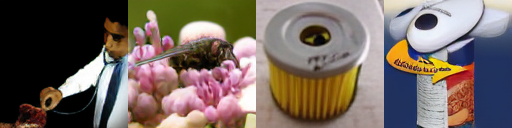

['a slug is sitting on a purple ball\n', 'a white wall switch with a light switch\n', 'a vintage coca cola machine in a garage\n', 'a golden retriever is smiling\n'] torch.Size([4, 32, 5, 4]) torch.Size([4, 50, 1024]) torch.Size([4, 50])


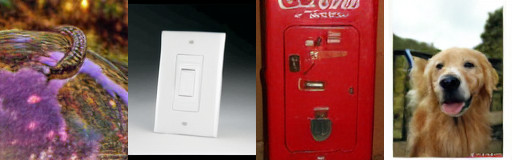

['a man on a bike doing a jump over a rock wall\n', 'a group of people in colorful costumes\n', 'a pair of knee pads\n', 'a red apple sitting on a rock\n'] torch.Size([4, 32, 4, 5]) torch.Size([4, 50, 1024]) torch.Size([4, 50])


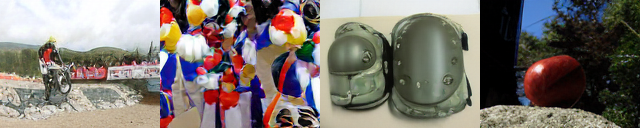

['a white bird sitting on top of a nest\n', 'a squirrel is sitting on a pile of leaves\n', 'a brown and white dog with its tongue out\n', 'a spider is sitting on a web in front of a wooden fence\n'] torch.Size([4, 32, 4, 4]) torch.Size([4, 50, 1024]) torch.Size([4, 50])


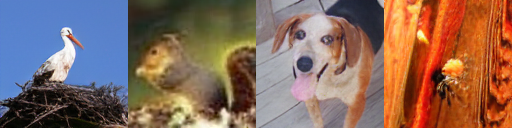

['a monkey is eating a piece of fruit\n', 'a man in a green shirt and black scarf playing a harp\n', 'boba fett cosplay at star wars convention\n', 'a corgi dog standing on top of a red box\n'] torch.Size([4, 32, 5, 4]) torch.Size([4, 50, 1024]) torch.Size([4, 50])


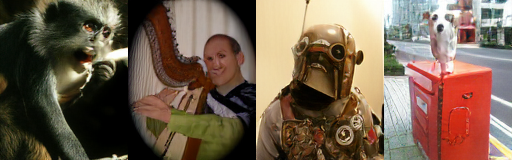

['a small orange lizard on the ground\n', 'a white coffee pot with a mercedes emblem on it\n', 'a bug on a plastic container\n', 'a room with a desk and a window\n'] torch.Size([4, 32, 4, 5]) torch.Size([4, 50, 1024]) torch.Size([4, 50])


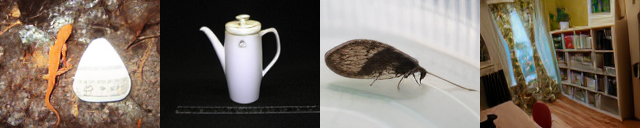

['a wooden trunk with leather handles and straps\n', 'two antique iron castings on a table\n', 'a lamp with a mosaic pattern on it\n', 'a group of people dressed in medieval clothing\n'] torch.Size([4, 32, 4, 4]) torch.Size([4, 50, 1024]) torch.Size([4, 50])


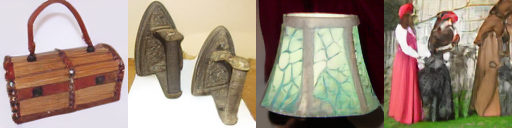

In [101]:
shape_dataset = ShapeBatchingDataset(
    hf_dataset=ds, 
    splits=["train_AR_1_to_1", "train_AR_3_to_4", "train_AR_4_to_3"], 
    text_enc=te, 
    tokenizer=tok,
    bs=4,
)

for idx, batch in enumerate(shape_dataset):
    labels, latents, label_embs, label_atnmasks = batch
    latents = latents.to(dtype).to(device)
    print(labels, latents.shape, label_embs.shape, label_atnmasks.shape)
    display(
        make_grid (latent_to_PIL(latents, dcae))
    )
    if idx>5: break

In [39]:
torch.Tensor(ds["train_AR_4_to_3"][0]["latent"]).shape

torch.Size([1, 32, 4, 5])

In [31]:
for batch in shape_dataset:
    labels, latents = batch
    print(latents.shape)
    break

torch.Size([3, 1, 32, 4, 4])


In [33]:
torch.stack([1, 2, 3])

TypeError: expected Tensor as element 0 in argument 0, but got int